In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

# transform = transforms.Normalize((0.1307,), (0.3081,))
transform = None

train_set = PreloadedDataset.from_dataset(train_set, transform, device)
val_set = PreloadedDataset.from_dataset(val_set, transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, transform, device)

In [4]:
def train(
        model,
        train_set,
        val_set,
        optimiser,
        criterion,
        n_epochs,
        batch_size,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1])

            x_hat = model(x)
            loss = criterion(x_hat, x)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        for x, _ in val_loader:
            x_hat = model(x)
            loss = criterion(x_hat, x)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
    return train_losses, val_losses

In [17]:
class LookupLinear(nn.Module):
    def __init__(self, in_features, num_classes, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, num_classes)
        self.embedding = nn.Embedding(num_classes, out_features)

    def forward(self, x):
        x = self.linear(x).softmax(dim=-1)
        out = torch.matmul(x, self.embedding.weight)
        return out

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),

            LookupLinear(784, 64, 512),
            nn.ReLU(),
            LookupLinear(512, 64, 256),
            nn.ReLU(),
            LookupLinear(256, 64, 128),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            LookupLinear(128, 64, 256),
            nn.ReLU(),
            LookupLinear(256, 64, 512),
            nn.ReLU(),
            LookupLinear(512, 64, 784),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28)),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
model = AutoEncoder().to(device)
LR = 3e-4
WD = 1e-5
EPOCHS = 30
BATCH_SIZE = 128

# criterion = F.binary_cross_entropy_with_logits
criterion = F.mse_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

train_losses, val_losses = train(model, train_set, val_set, optimizer, criterion, EPOCHS, BATCH_SIZE)

Best Validation Loss: 0.05772537476521857


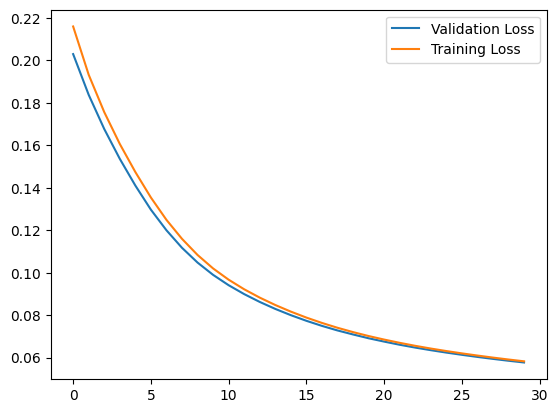

In [19]:
print(f'Best Validation Loss: {min(val_losses)}')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend()

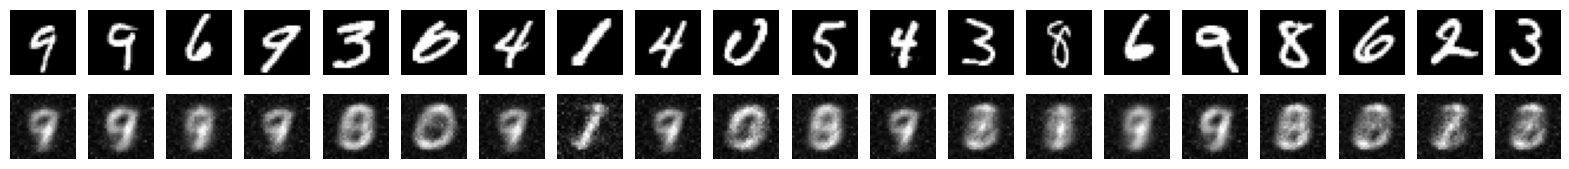

In [20]:
sample_size = 20
idxs = torch.randint(0, len(test_set), (sample_size,))

fig, axes = plt.subplots(2, sample_size, figsize=(sample_size, 2))
for i, idx in enumerate(idxs):
    x, _ = test_set[idx]
    x_hat = model(x.unsqueeze(0))
    axes[0, i].imshow(x.squeeze().cpu(), cmap='gray')
    axes[1, i].imshow(x_hat.squeeze().cpu().detach(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.show()

In [21]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(128, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            x = model.encoder(x)
            pred = classifier(x.detach())
            loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            x = model.encoder(x)
            pred = classifier(x)
            loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [22]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, EPOCHS, BATCH_SIZE)

Best Validation Accuracy: 93.23%


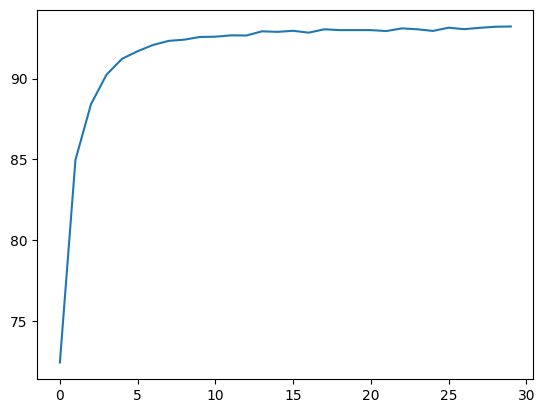

In [25]:
print(f'Best Validation Accuracy: {max(c_v_accs):.2f}%')
plt.plot(c_v_accs, label='Validation Accuracy')

In [24]:
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

mse_losses = []
with torch.no_grad():
    for images, label in test_loader:
        recon = model(images)
        mse = F.mse_loss(recon, images)
        mse_losses.append(mse.item())

print(f'Test MSE Loss: {sum(mse_losses) / len(mse_losses)}')

Test MSE Loss: 0.004712504941875799
